### Importing necessary packages

In [520]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import boto3
import botocore
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind_from_stats
from scipy import stats

## How jupyter notebook is build:

- 1) Sanity checks that A/B test was well implemented
- 2) Understanding and exploring data
- 3) KPI's to evaluate algorithm
- 4) Where algorithm works better and worst ?
- 5) Conclusion
- 6) Possible improvements

### Loading data

In [72]:
url = 'https://dh-data-chef-hiring-test.s3.eu-central-1.amazonaws.com/prep_time_test.gz'
df = pd.read_parquet(url , engine='pyarrow' )

In [73]:
pd.set_option('display.max_columns', None)
df.head(8)

,order_id,created_timestamp_local,estimated_delivery_time_local,customer_id,vendor_id,chain_id,city,distance_straightline,order_value,order_items_count,accepted_timestamp_local,cancelled_timestamp_local,cancelled_owner,cancelled_reason,cancelled_source,promised_delivery_time,split,driving_time_formula,control_prep_time,estimated_delivery_time_bucket,variant_prep_time,clutser_model
0,144018,2020-01-22 23:11:52+00:00,2020-01-22 23:48:52,84771,1266,NaN,karachi,4999.836722,570.0,3,2020-01-22 23:12:09.400,NaT,None,None,None,37.0,variant,22,25,40.0,12.0,0
1,143929,2020-01-23 00:09:05+00:00,2020-01-23 00:45:05,50619,1266,NaN,karachi,4682.722019,430.0,2,2020-01-23 00:09:34.517,NaT,None,None,None,36.0,variant,21,25,40.0,12.0,0
2,125075,2020-01-23 03:00:38+00:00,2020-01-23 03:31:38,51806,1091,NaN,lahore,2391.329858,495.0,1,2020-01-23 03:01:09.772,NaT,None,None,None,31.0,variant,13,25,35.0,15.0,0
3,125051,2020-01-22 23:42:06+00:00,2020-01-23 00:19:06,98354,1091,NaN,lahore,2264.920034,495.0,1,2020-01-22 23:42:48.269,NaT,None,None,None,37.0,control,12,25,40.0,15.0,0
4,125092,2020-01-22 23:55:08+00:00,2020-01-23 00:30:08,5053,1091,NaN,lahore,1583.463172,495.0,1,2020-01-22 23:55:36.737,NaT,None,None,None,35.0,control,10,25,35.0,15.0,0
5,125091,2020-01-23 00:15:58+00:00,2020-01-23 00:50:58,91190,1091,NaN,lahore,1661.152587,630.0,2,2020-01-23 00:16:23.136,NaT,None,None,None,35.0,control,10,25,35.0,15.0,0
6,125087,2020-01-23 03:12:35+00:00,2020-01-23 03:45:35,66701,1091,NaN,lahore,3012.594343,615.0,3,2020-01-23 03:13:34.949,NaT,None,None,None,33.0,variant,15,25,35.0,15.0,0
7,125088,2020-01-23 01:06:24+00:00,2020-01-23 01:36:24,23453,1091,NaN,lahore,348.167408,310.0,1,2020-01-23 01:06:48.423,NaT,None,None,None,30.0,control,5,25,30.0,15.0,0


## Check of possible bugs in data

#### 1) We should see that for every case : created_timestamp_local + promised_delivery_time = estimated_delivery_time_local

In [66]:
def check_if_created_timestamp_plus_delivertime_equal_estimateddeliverytime(df):
    df['time_check'] = df['created_timestamp_local'] + pd.to_timedelta(df['promised_delivery_time'] , unit='m')
    df['time_check'] = df['time_check'].dt.tz_localize(None)
    df['difference_in_time'] = df['time_check'] - df['estimated_delivery_time_local']
    return df['difference_in_time'].value_counts()

In [67]:
check_if_created_timestamp_plus_delivertime_equal_estimateddeliverytime(df)

00:00:00                    145486
-1 days +23:59:59.999999      1144
00:00:00.000000                 44
-1 days +23:59:59.999999         2
Name: difference_in_time, dtype: int64

Values are correct , those values which are not zero are mainly due to the impossibility of the function of pd.timedelta to deal with periodic numbers like 95.633333333

#### 2) Check if data downloaded is from the same days

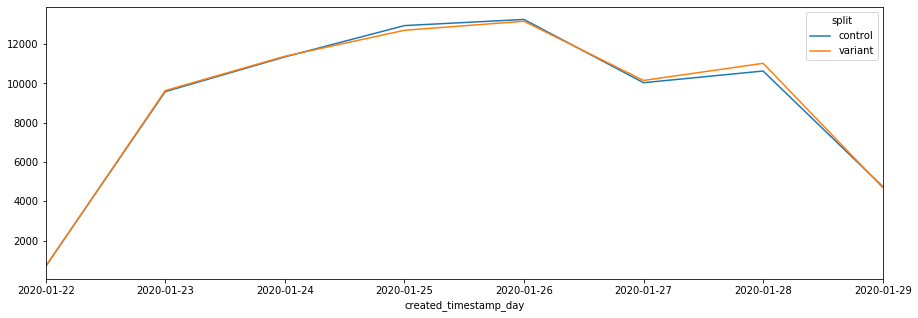

In [79]:
df['created_timestamp_day'] = df['created_timestamp_local'].dt.strftime('%Y-%m-%d')
df.pivot_table(index='created_timestamp_day' , columns='split' , values='order_id' , aggfunc=pd.Series.nunique).plot(figsize=(15,5))

Based on this data we can also infer that the split of the A/B test was 50/50

#### 3) Check that there is not selection biased in the A/B test

- 3.1) We should not expected that a certain city is more represented in one group than in another (as we have 50/50 split A/B test)
- 3.2) Inside each variant should see a 50/50 split of orders inside each cluster , so there is no overrepresentation of one specific cluster in one specific group
- 3.3) Driving_time_formula should show a similar distribution in both group

#### 3.1

In [121]:
def city_control_biased(df):
    
    # Sum amount of orders in control and variant for each city
    city_check = df.pivot_table(index='city' , values='order_id' , columns='split' , aggfunc=pd.Series.nunique).fillna(0)
    
    # Calculate % of order in each split
    city_check['sum'] = city_check['control'] + city_check['variant']
    city_check['percentage_control'] = city_check['control'] / city_check['sum']
    city_check['percentage_variant'] = city_check['variant'] / city_check['sum']
    city_check = city_check.sort_values(by='sum', ascending = False)

    # We are going to check 20% of the cities with higher volume , cities with low volume we could see easily a no split of 50/50 split just because got low volume
    n_x = round(city_check.shape[0] / 5)
    
    # Graph the 20% of cities with higher orders
    return city_check[:n_x][['percentage_control' , 'percentage_variant']].plot.bar(stacked=True , figsize=(15,5) , title='Split of orders for each city for each A/B group')

C:\Users\ldresl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ldresl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)


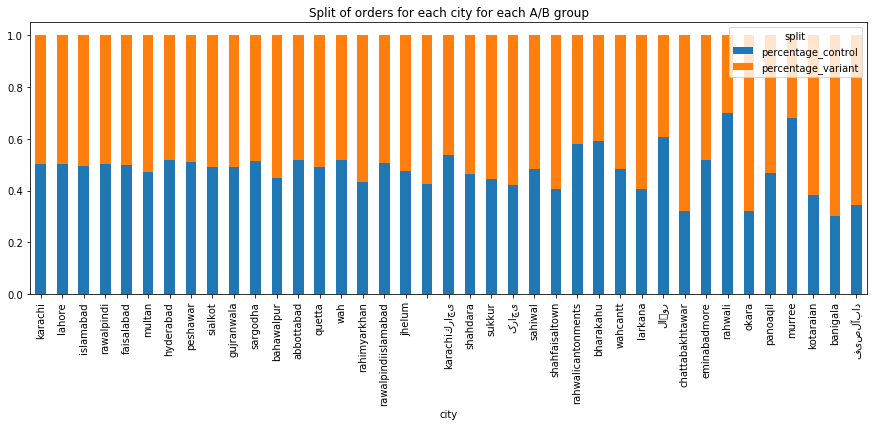

In [122]:
city_control_biased(df)

We can see mostly every city is having a 50/50 split , city at the last have "low" volume

#### 3.2

In [123]:
def cluster_control_biased(df):
    
    # Sum amount of orders in control and variant for each cluster model
    cluster_check = df.pivot_table(index='clutser_model' , columns='split' , values='order_id' , aggfunc=pd.Series.nunique)
    
    # Calculate % of order in each cluster
    cluster_check['sum'] = cluster_check['control'] + cluster_check['variant']
    cluster_check['percentage_control'] = cluster_check['control'] / cluster_check['sum']
    cluster_check['percentage_variant'] = cluster_check['variant'] / cluster_check['sum']
    
    # Graph
    return cluster_check[['percentage_control' , 'percentage_variant']].plot.bar(stacked=True , figsize=(15,5) , 
                                                                                title='Split of orders for each cluster model for each A/B group')

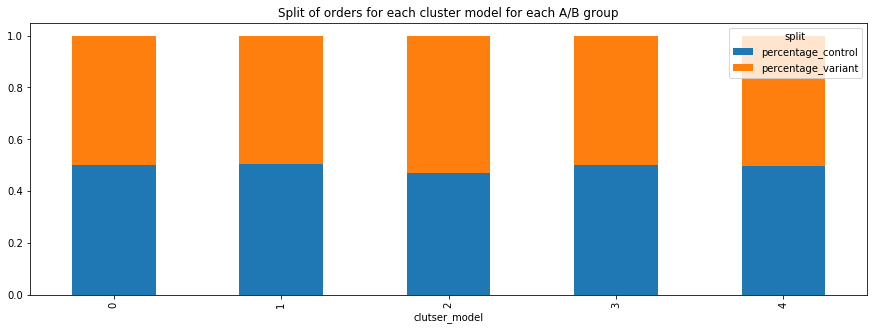

In [124]:
cluster_control_biased(df)

We see 50/50 split in the amount of order for each cluster

#### 3.3

Let's see if there is any selected bias in the driving_time_formula: for that we are going to compare distribution among the two groups for the values of driving_time_formula

Mean values for driving time formula
split
control    12.226440
variant    12.191985
Name: driving_time_formula, dtype: float64


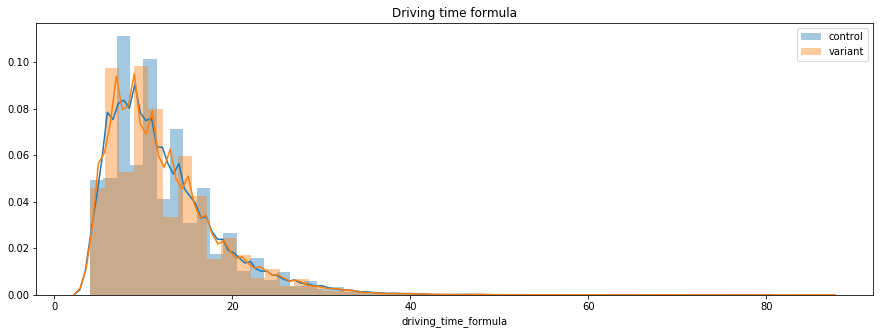

In [132]:
fig , ax1 = plt.subplots(1,1,figsize=(15,5))

sns.distplot(df[df['split'] == 'control'].driving_time_formula , ax=ax1 , label='control')
sns.distplot(df[df['split'] == 'variant'].driving_time_formula , ax=ax1 , label='variant')
ax1.set_title('Driving time formula')
ax1.legend()

print('Mean values for driving time formula')
print(df.groupby('split')['driving_time_formula'].mean())

#### Looks like there is no biases in the implementation of the A/B test. We are good to proceed

## Data exploration and understanding of the data

In [182]:
df_variant.head()

,order_id,created_timestamp_local,estimated_delivery_time_local,customer_id,vendor_id,chain_id,city,distance_straightline,order_value,order_items_count,accepted_timestamp_local,cancelled_timestamp_local,cancelled_owner,cancelled_reason,cancelled_source,promised_delivery_time,split,driving_time_formula,control_prep_time,estimated_delivery_time_bucket,variant_prep_time,clutser_model,created_timestamp_day,promised_delivery_time_control,estimated_bucket_for_control,higher_variant_than_control_time,estimated_delivery_bucket_control
0,144018,2020-01-22 23:11:52+00:00,2020-01-22 23:48:52,84771,1266,NaN,karachi,4999.836722,570.00,3,2020-01-22 23:12:09.400,NaT,None,None,None,37.0,variant,22,25,40.0,12.0,0,2020-01-22,47,45.0,0,50
1,143929,2020-01-23 00:09:05+00:00,2020-01-23 00:45:05,50619,1266,NaN,karachi,4682.722019,430.00,2,2020-01-23 00:09:34.517,NaT,None,None,None,36.0,variant,21,25,40.0,12.0,0,2020-01-23,46,45.0,0,50
2,125075,2020-01-23 03:00:38+00:00,2020-01-23 03:31:38,51806,1091,NaN,lahore,2391.329858,495.00,1,2020-01-23 03:01:09.772,NaT,None,None,None,31.0,variant,13,25,35.0,15.0,0,2020-01-23,38,40.0,0,40
6,125087,2020-01-23 03:12:35+00:00,2020-01-23 03:45:35,66701,1091,NaN,lahore,3012.594343,615.00,3,2020-01-23 03:13:34.949,NaT,None,None,None,33.0,variant,15,25,35.0,15.0,0,2020-01-23,40,40.0,0,40
10,129651,2020-01-23 01:13:10+00:00,2020-01-23 01:53:10,91401,1157,225.0,karachi,2644.114384,924.34,2,2020-01-23 01:13:43.164,NaT,None,None,None,40.0,variant,13,25,40.0,24.0,1,2020-01-23,38,40.0,1,40


#### Understand where the estimates of the Variant formula sit when compared to the Control formula. Is the Variant estimating the same time, is estimating more delivery time or constantly less delivery time? Analysis done by cluster

- Control : Estimated delivery time = Constant preparation ( 25 mins ) + Driving time formula
- Variant : Estimated delivery time = New model for prep time + Driving time formula

Comparison of promised delivery time for the control and variant formula

C:\Users\ldresl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ldresl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5, 1.0, 'Promised time continous')

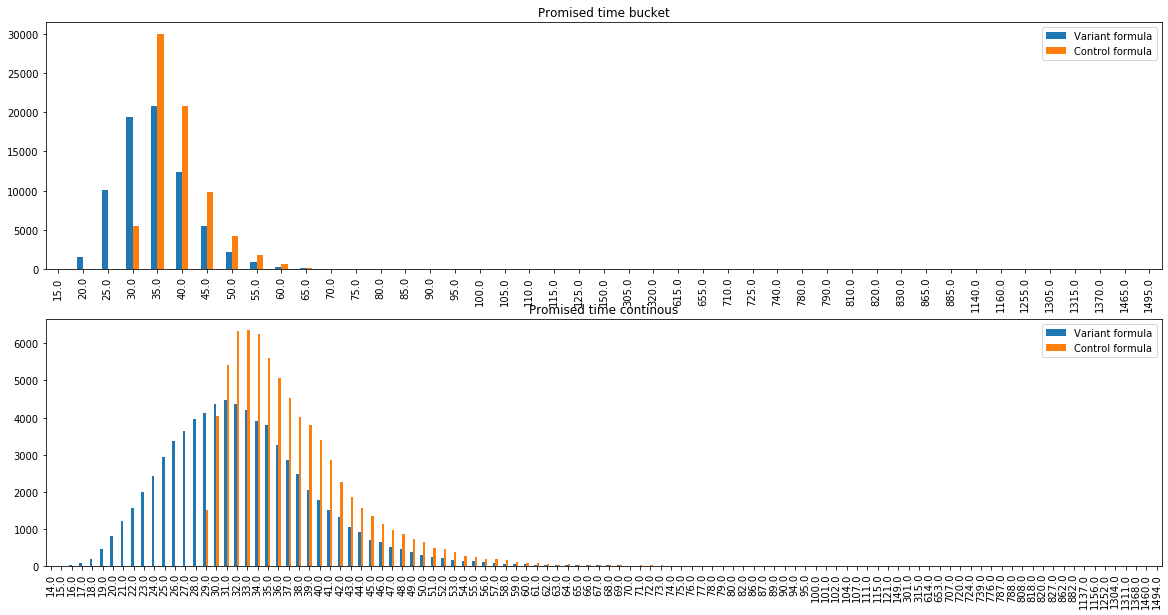

In [222]:
# Filter only variant values (this is because we only have the estimation of the new formula in this group)
df_variant = df[df['split'] == 'variant']

df_variant['promised_delivery_time_control'] = df_variant['control_prep_time'] + df_variant['driving_time_formula']
df_variant['estimated_delivery_bucket_control'] = np.round_((np.ceil(df_variant['promised_delivery_time_control']/5)*5)).astype(int)

# Compare control vs variant formula promised time
fig , (ax1 , ax2) = plt.subplots(2,1,figsize=(20,20))
graph_df_1 = df_variant['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())

graph_df_1.plot(kind='bar' , figsize=(20,10) , ax=ax1)
ax1.set_title('Promised time bucket')

graph_df_2 = round(df_variant['promised_delivery_time']).value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant['promised_delivery_time_control'].value_counts().sort_index().rename('Control formula').to_frame())

graph_df_2.plot(kind='bar' , figsize=(20,10) , ax=ax2)
ax2.set_title('Promised time continous')

- So as expected in the graph above we are seeing that in the variant group , the promised time contains lower values than the control formula.
- Let's see now if this distribution changes by cluster (we are going to see only the bucket graph for simplicity)

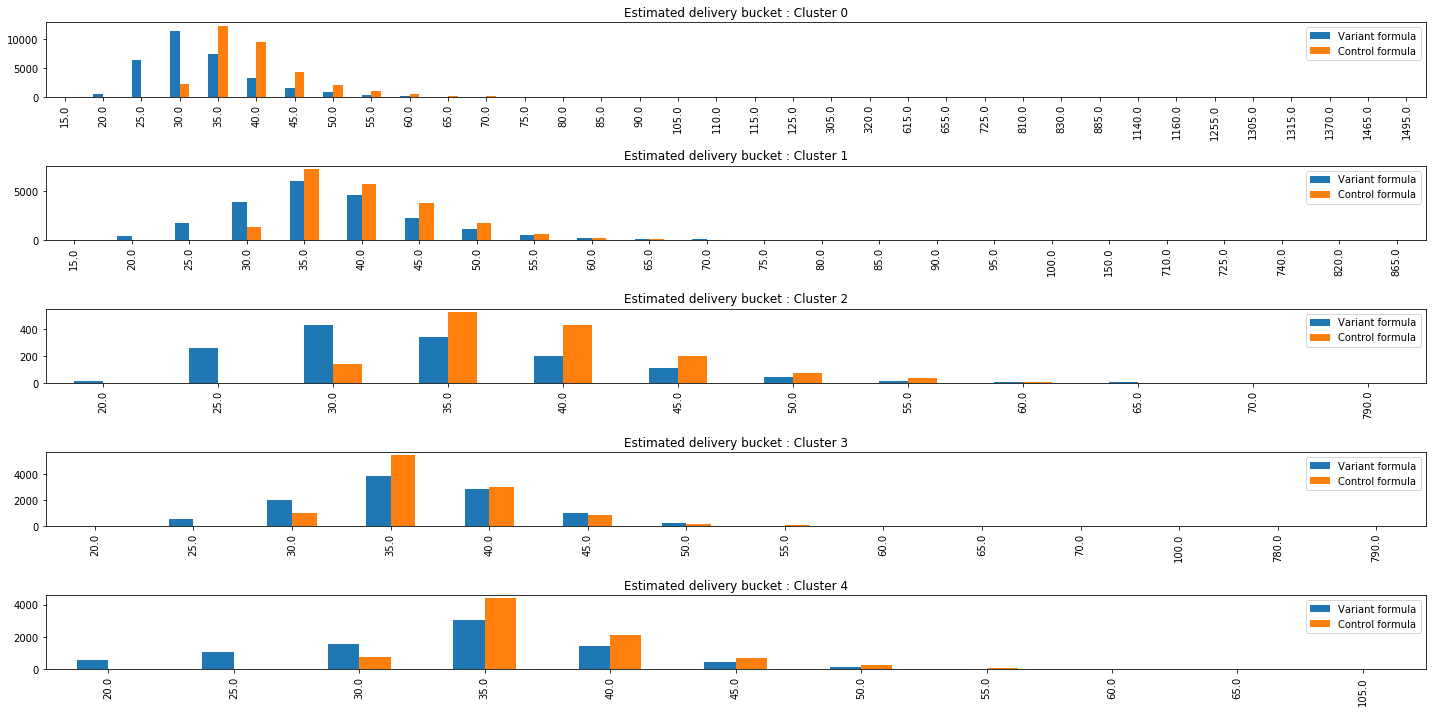

In [235]:
fig , (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5 , 1 , figsize=(15,5))

# Plot cluster 0 
df_variant_0 = df_variant[df_variant['clutser_model'] == 0]
graph_0 = df_variant_0['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant_0['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())
graph_0.plot(kind='bar' , figsize=(20,10) , ax=ax1)
ax1.set_title('Estimated delivery bucket : Cluster 0')

# Plot cluster 1
df_variant_1 = df_variant[df_variant['clutser_model'] == 1]
graph_1 = df_variant_1['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant_1['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())
graph_1.plot(kind='bar' , figsize=(20,10) , ax=ax2)
ax2.set_title('Estimated delivery bucket : Cluster 1')

# Plot cluster 2 
df_variant_2 = df_variant[df_variant['clutser_model'] == 2]
graph_2 = df_variant_2['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant_2['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())
graph_2.plot(kind='bar' , figsize=(20,10) , ax=ax3)
ax3.set_title('Estimated delivery bucket : Cluster 2')

# Plot cluster 3
df_variant_3 = df_variant[df_variant['clutser_model'] == 3]
graph_3 = df_variant_3['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant_3['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())
graph_3.plot(kind='bar' , figsize=(20,10) , ax=ax4)
ax4.set_title('Estimated delivery bucket : Cluster 3')

# Plot cluster 4
df_variant_4 = df_variant[df_variant['clutser_model'] == 4]
graph_4 = df_variant_4['estimated_delivery_time_bucket'].value_counts().sort_index().rename('Variant formula').to_frame()\
               .join(df_variant_4['estimated_delivery_bucket_control'].value_counts().sort_index().rename('Control formula').to_frame())
graph_4.plot(kind='bar' , figsize=(20,10) , ax=ax5)
ax5.set_title('Estimated delivery bucket : Cluster 4')

fig.tight_layout()

In [174]:
df_variant['higher_variant_than_control_time'] = np.where(df_variant['promised_delivery_time'] > df_variant['promised_delivery_time_control'] , 1 , 0)
df_variant['higher_variant_than_control_time'].value_counts()

C:\Users\ldresl\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    61901
1    11537
Name: higher_variant_than_control_time, dtype: int64

In [193]:
df_variant.groupby(['clutser_model' , 'higher_variant_than_control_time'])['higher_variant_than_control_time'].count()

clutser_model  higher_variant_than_control_time
0              0                                   31974
               1                                     246
1              0                                   15196
               1                                    5664
2              0                                    1243
               1                                     191
3              0                                    6496
               1                                    4087
4              0                                    6992
               1                                    1349
Name: higher_variant_than_control_time, dtype: int64

- We can see as more similar are the distribution of estimated time more chances are than the estimated deliver time for the control group is lower than the variant group. 
- cluster 3 seems to be the cluster where are more orders where the delivery time estimated for the control group is lower than the variant group
- cluster 1 is vary rare to see that the delivery time estimated in the control group is higher than the variant group

#### Understand more about the clusters and their clustering variables.

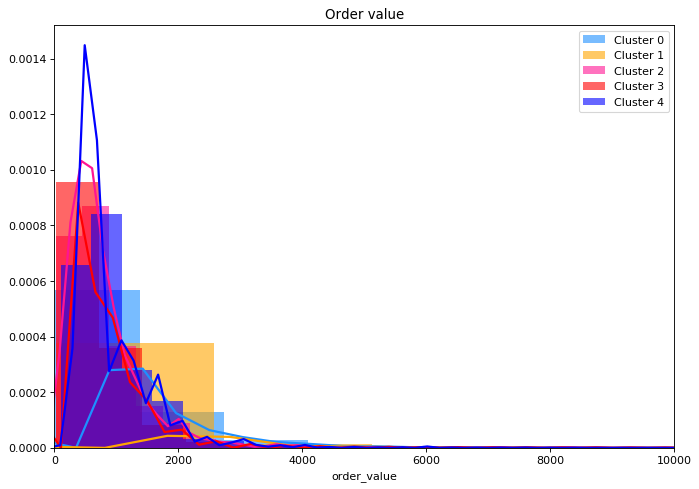

In [271]:
x0 = df.loc[df.clutser_model==0, 'order_value']
x1 = df.loc[df.clutser_model==1, 'order_value']
x2 = df.loc[df.clutser_model==2, 'order_value']
x3 = df.loc[df.clutser_model==3, 'order_value']
x4 = df.loc[df.clutser_model==4, 'order_value']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x0, color="dodgerblue", label="Cluster 0", **kwargs)
sns.distplot(x1, color="orange", label="Cluster 1", **kwargs)
sns.distplot(x2, color="deeppink", label="Cluster 2", **kwargs)
sns.distplot(x3, color="r", label="Cluster 3", **kwargs)
sns.distplot(x4, color="b", label="Cluster 4", **kwargs)
plt.xlim(0,10000)
plt.title('Order value')
plt.legend();

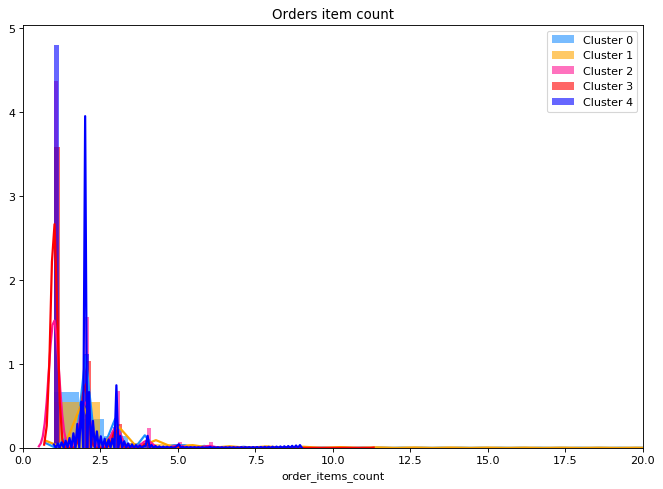

In [270]:
x0 = df.loc[df.clutser_model==0, 'order_items_count']
x1 = df.loc[df.clutser_model==1, 'order_items_count']
x2 = df.loc[df.clutser_model==2, 'order_items_count']
x3 = df.loc[df.clutser_model==3, 'order_items_count']
x4 = df.loc[df.clutser_model==4, 'order_items_count']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x0, color="dodgerblue", label="Cluster 0", **kwargs)
sns.distplot(x1, color="orange", label="Cluster 1", **kwargs)
sns.distplot(x2, color="deeppink", label="Cluster 2", **kwargs)
sns.distplot(x3, color="r", label="Cluster 3", **kwargs)
sns.distplot(x4, color="b", label="Cluster 4", **kwargs)
plt.title('Orders item count')
plt.xlim(0,20)
plt.legend();

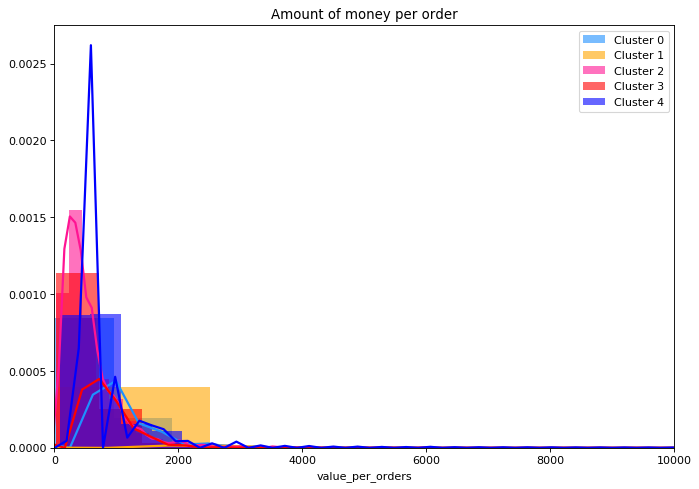

In [269]:
# Amount of money per order
df['value_per_orders'] = df['order_value'] / df['order_items_count']

x0 = df.loc[df.clutser_model==0, 'value_per_orders']
x1 = df.loc[df.clutser_model==1, 'value_per_orders']
x2 = df.loc[df.clutser_model==2, 'value_per_orders']
x3 = df.loc[df.clutser_model==3, 'value_per_orders']
x4 = df.loc[df.clutser_model==4, 'value_per_orders']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x0, color="dodgerblue", label="Cluster 0", **kwargs)
sns.distplot(x1, color="orange", label="Cluster 1", **kwargs)
sns.distplot(x2, color="deeppink", label="Cluster 2", **kwargs)
sns.distplot(x3, color="r", label="Cluster 3", **kwargs)
sns.distplot(x4, color="b", label="Cluster 4", **kwargs)
plt.xlim(0,10000)
plt.title('Amount of money per order')
plt.legend();

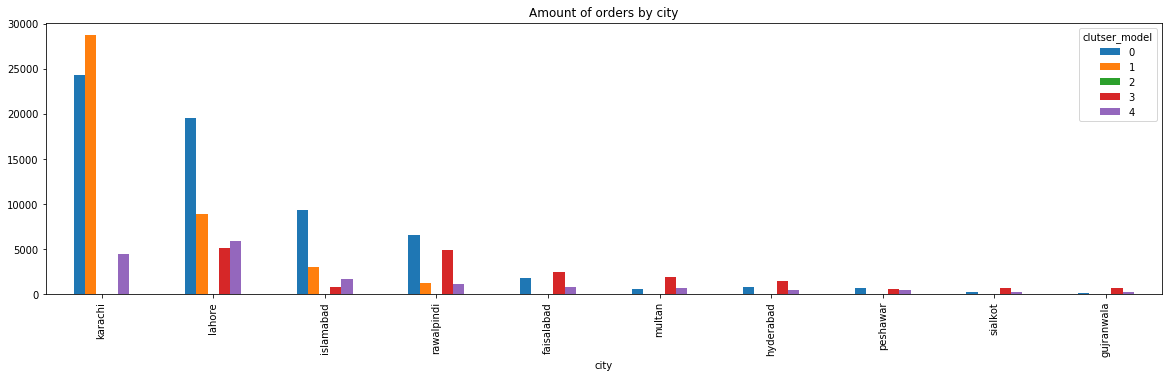

In [496]:
cities = df.pivot_table(index='city' , columns='clutser_model' , values='order_id' , aggfunc=pd.Series.nunique ).fillna(0)
cities['total'] = cities.sum(axis=1)
cities.sort_values(by='total' , ascending=False)[:10][[0,1,2,3,4]].plot(kind='bar' , figsize=(20,5) , title='Amount of orders by city')

Making research in internet we interpret that cluster 2 usually represent rural areas (that's why we see higher distances)

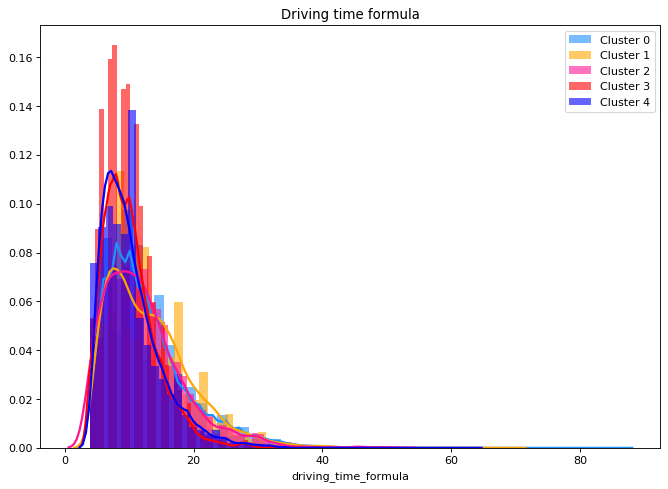

In [273]:
x0 = df.loc[df.clutser_model==0, 'driving_time_formula']
x1 = df.loc[df.clutser_model==1, 'driving_time_formula']
x2 = df.loc[df.clutser_model==2, 'driving_time_formula']
x3 = df.loc[df.clutser_model==3, 'driving_time_formula']
x4 = df.loc[df.clutser_model==4, 'driving_time_formula']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x0, color="dodgerblue", label="Cluster 0", **kwargs)
sns.distplot(x1, color="orange", label="Cluster 1", **kwargs)
sns.distplot(x2, color="deeppink", label="Cluster 2", **kwargs)
sns.distplot(x3, color="r", label="Cluster 3", **kwargs)
sns.distplot(x4, color="b", label="Cluster 4", **kwargs)
#plt.xlim(0,10000)
plt.title('Driving time formula')
plt.legend();

#### Understanding if there is a corrolation between the delay of accepting an order and the peak hours

Text(0.5, 1.0, 'Corrolation between peak hours and delay of accepting the order')

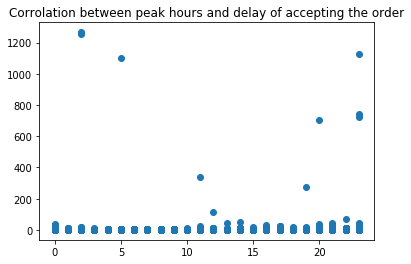

In [584]:
df['created_timestamp_local'] = df['created_timestamp_local'].dt.tz_localize(None)
df['difference_created_and_accepted'] = (df['accepted_timestamp_local'] - df['created_timestamp_local']).astype('timedelta64[m]')
plt.scatter(df['hour'] , df['difference_created_and_accepted'])
plt.title('Corrolation between peak hours and delay of accepting the order')

There is no corrolation between peak hours and delay of accepting the order

## KPI evaluation 

- Amount of orders :
    - Hypothesis : 
        - As in the variant group is shown delivery time fasters in the UI than in control is expected to increase number of orders , in a ceteris paribus scenario (keeping all the other variables steady)
        - But if more items are shown with a less delivery time in the variant scenario than the control and that promised delivery time is not fullfill can generate a bad experience in the users ( to watch this behaviour we are going to see a metric called # repeated user , "a retention metric" )


- Retention metric : Amount of orders per user "stickness metric"
    - Hypothesis :
        - Watching a higher "stickness" in one group than in another could be corrolated with the fact that we are estimating better the delivery time
        

- Amount of money spend:
    - Hypothesis :
        - I imagine that delivery hero wins more money for more money spend by users in the platform ( because of comissions )

#### Amount of orders

         order_id
split            
control     73238
variant     73438


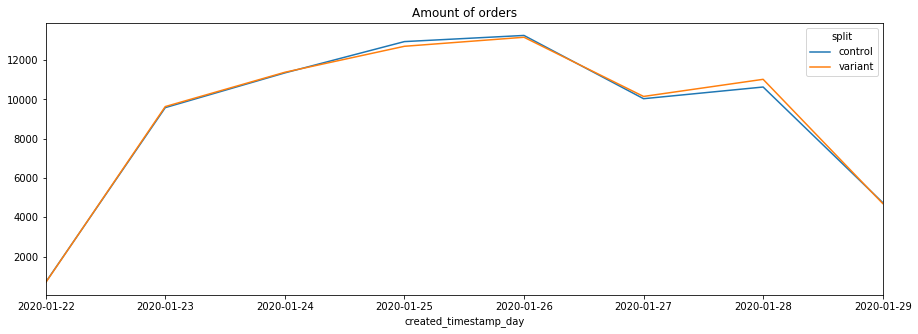

In [477]:
#df_accept = df[df.accepted_timestamp_local.notnull()]
amount_of_orders = df.groupby('split')['order_id'].nunique().to_frame()
print(amount_of_orders)
df.pivot_table(index='created_timestamp_day' , columns='split' , values='order_id' , aggfunc=pd.Series.nunique).plot(figsize=(15,5) , title='Amount of orders')

In [357]:
print('Increase amount of orders by ' + str(((amount_of_orders[1:2].values / amount_of_orders[:1].values) - 1) * 100) + '%') 

Increase amount of orders by [[0.27308228]]%


#### Orders by user

In [475]:
order_by_user_day = df.pivot_table(index='created_timestamp_day' , columns='split' , values=['customer_id' , 'order_id'] ,
                                aggfunc=pd.Series.nunique)
order_by_user_day['order_by_user_control'] =  order_by_user_day['order_id']['control'] / order_by_user_day['customer_id']['control']
order_by_user_day['order_by_user_variant'] =  order_by_user_day['order_id']['variant'] / order_by_user_day['customer_id']['variant']

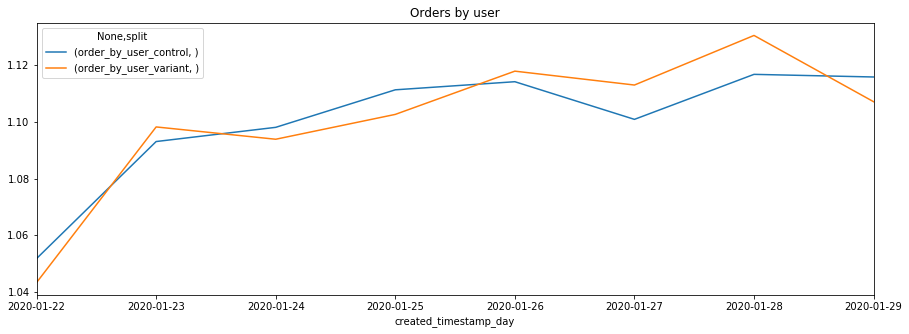

In [476]:
order_by_user_day[['order_by_user_control' , 'order_by_user_variant']].plot(figsize=(15,5) , title='Orders by user')

In [360]:
# No split by day
order_by_user = df.pivot_table(index='split' , values=['customer_id' , 'order_id'] ,
                                aggfunc=pd.Series.nunique)

In [361]:
order_by_user['order_by_user'] =  order_by_user['order_id'] / order_by_user['customer_id']

         order_by_user
split                 
control       1.358700
variant       1.365983


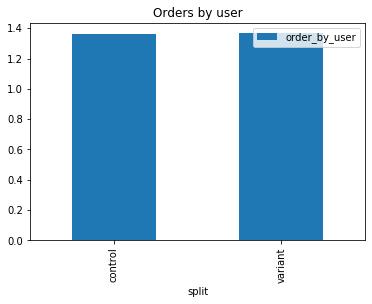

In [362]:
print(order_by_user[['order_by_user']])
order_by_user[['order_by_user']].plot(kind='bar' , title='Orders by user')

In [370]:
print('Increase in orders per user : ' + str(round(((order_by_user.iloc[1,2]  / order_by_user.iloc[0,2]) - 1) * 100 , 2)) + '%')

Increase in orders per user : 0.54%


- Statistics signficance

In [528]:
data = df.pivot_table(index=['customer_id' , 'split']  , values='order_id' , aggfunc=pd.Series.nunique).reset_index()
A = np.array(data[data['split'] == 'control'].order_id)
B = np.array(data[data['split'] == 'variant'].order_id)
stats.ttest_ind(A , B)

Ttest_indResult(statistic=-1.3838623260443534, pvalue=0.16640348322386642)

Not rejection of the hypothesis that the orders per user is similar in both group

#### Amount of money spend per order

In [381]:
money_per_order = df.pivot_table(index='split' , values=['order_id','order_items_count' ,'order_value'] , 
                      aggfunc={'order_id':pd.Series.nunique , 'order_value':'sum' , 'order_items_count':'sum'})
money_per_order['money_per_order'] = money_per_order['order_value'] / money_per_order['order_id']
money_per_order['money_per_totalsorder'] = money_per_order['order_value'] / money_per_order['order_items_count']
money_per_order

,order_id,order_items_count,order_value,money_per_order,money_per_totalsorder
split,,,,,
control,73238,123220,7.045904e+07,962.055828,571.815003
variant,73438,123144,7.130432e+07,970.945777,579.031995


In [397]:
print('Increase in money spend : ' + str(round((money_per_order.iloc[1 , 2] / money_per_order.iloc[0 , 2]) -1 , 2)*100) + '%')
print('Increase in money per total orders : ' + str(round((money_per_order.iloc[1 , 4] / money_per_order.iloc[0 , 4]) -1 , 2)*100) + '%')
print('Increase money per order : ' + str(round((money_per_order.iloc[1 , 3] / money_per_order.iloc[0 , 3]) -1 , 2)*100) + '%')

Increase in money spend : 1.0%
Increase in money per total orders : 1.0%
Increase money per order : 1.0%


- Statistical significance

In [529]:
A = np.array(df[df['split'] == 'control'].order_value)
B = np.array(df[df['split'] == 'variant'].order_value)
stats.ttest_ind(A , B)

Ttest_indResult(statistic=-1.3304099179085735, pvalue=0.18338531702765704)

Not rejection of the hypothesis that the orders per user is similar in both group

##### Summary : Increase in all money spend metrics and stickiness metric , new model seems to work better overall

## Where does the new model shine and were works poorly ?

#### Amount of orders by cluster model

In [486]:
order_by_user_model = df.pivot_table(index='clutser_model' , columns='split' , values=['customer_id' , 'order_id'] ,
                                aggfunc=pd.Series.nunique)
order_by_user_model['order_by_user_control'] =  order_by_user_model['order_id']['control'] / order_by_user_model['customer_id']['control']
order_by_user_model['order_by_user_variant'] =  order_by_user_model['order_id']['variant'] / order_by_user_model['customer_id']['variant']

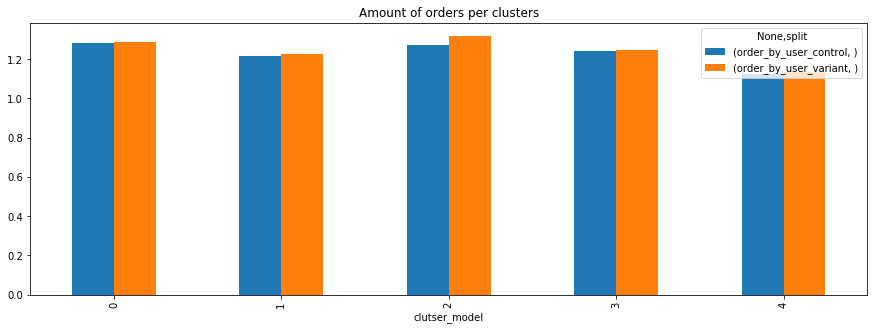

In [487]:
order_by_user_model[['order_by_user_control' , 'order_by_user_variant']].plot(kind='bar',figsize=(15,5) , title='Amount of orders per clusters')

- New model works better in cluster 2 for amount of orders ( cluster 2 is associated with low values of orders which are in a long distance )

#### Amount of orders per city

In [502]:
order_by_user_city = df.pivot_table(index='city' , columns='split' , values=['customer_id' , 'order_id'] ,
                                aggfunc=pd.Series.nunique)
order_by_user_city['totalorders'] = order_by_user_city.sum(axis=1)
order_by_user_city['order_by_user_control'] =  order_by_user_city['order_id']['control'] / order_by_user_city['customer_id']['control']
order_by_user_city['order_by_user_variant'] =  order_by_user_city['order_id']['variant'] / order_by_user_city['customer_id']['variant']

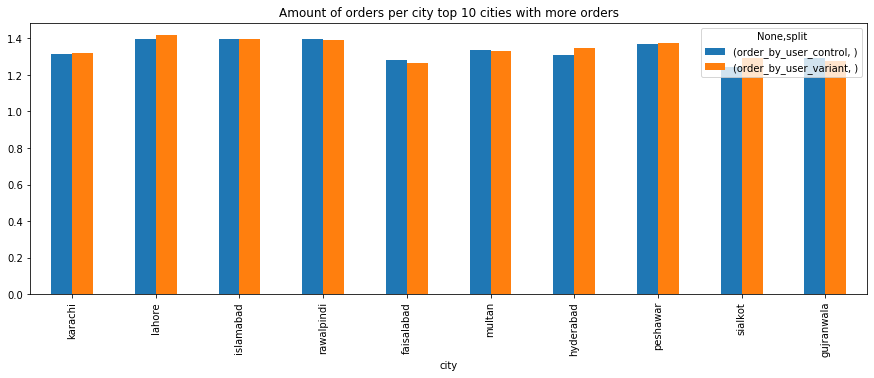

In [503]:
order_by_user_city.sort_values(by='totalorders' , ascending=False)[:10][['order_by_user_control' , 'order_by_user_variant']].plot(kind='bar' , figsize=(15,5) , title='Amount of orders per city top 10 cities with more orders')

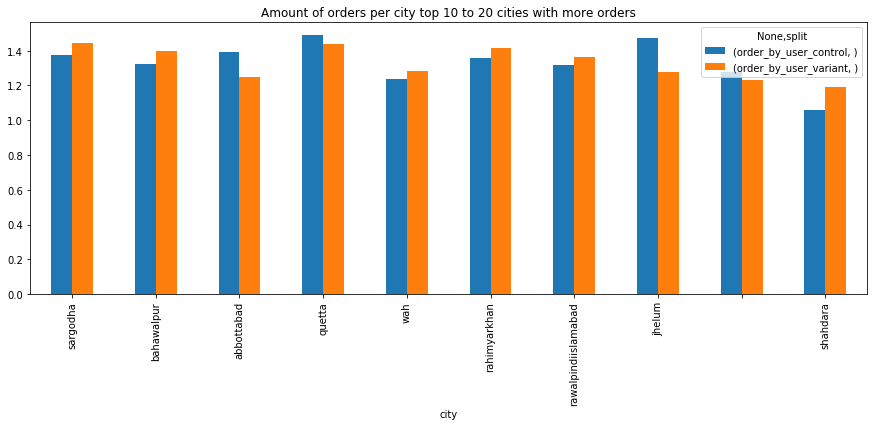

In [504]:
order_by_user_city.sort_values(by='totalorders' , ascending=False)[10:20][['order_by_user_control' , 'order_by_user_variant']].plot(kind='bar' , figsize=(15,5) , title='Amount of orders per city top 10 to 20 cities with more orders')

- From the top cities with orders sialkot seems to be the one where the new model was outperforming
- Model seems to be working better in less centric areas

#### Amount of money spend and amount of money spend per order

In [484]:
money_per_order_cluster = df.pivot_table(index='clutser_model' , columns='split' , values=['order_value' , 'order_id'] ,
                                aggfunc={'order_id':pd.Series.nunique , 'order_value':'sum'})

money_per_order_cluster['money_per_order_control'] =  money_per_order_cluster['order_value']['control'] / money_per_order_cluster['order_id']['control']
money_per_order_cluster['money_per_order_variant'] =  money_per_order_cluster['order_value']['variant'] / money_per_order_cluster['order_id']['variant']

#money_per_order_cluster['difference%'] = 
money_per_order_cluster

order_id          order_value               \
split          control variant      control      variant   
clutser_model                                              
0                32032   32220  34774547.11  35040400.85   
1                21085   20860  20647396.90  20835172.20   
2                 1272    1434    973549.52   1176019.51   
3                10576   10583   7007855.11   7057162.86   
4                 8273    8341   7055696.07   7195560.52   

              money_per_order_control money_per_order_variant  
split                                                          
clutser_model                                                  
0                         1085.618978             1087.535718  
1                          979.245762              998.809789  
2                          765.369119              820.097287  
3                          662.618675              666.839541  
4                          852.858222              862.673603

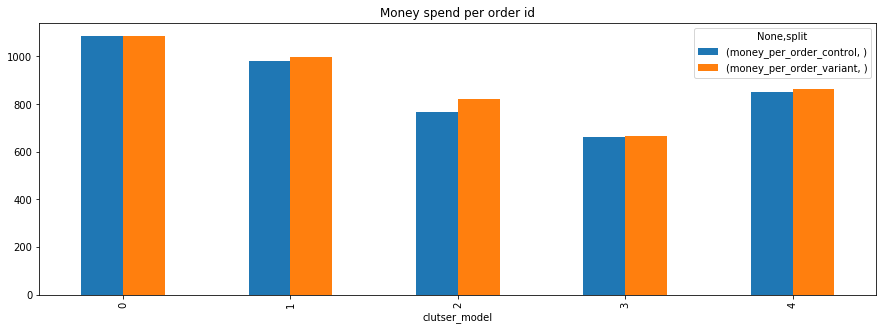

In [485]:
money_per_order_cluster[['money_per_order_control' , 'money_per_order_variant']].plot(kind='bar',figsize=(15,5) , title='Money spend per order id')

- Again cluster 2 seems to be outperforming for amount of money spend per order id

#### We are estimating correctly for different distances ? maybe model work good in long distance but in low distance not that good

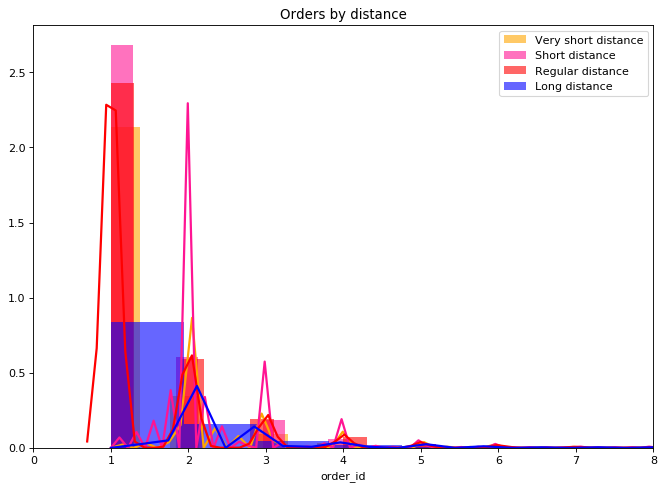

In [495]:
# Dataframe per customer and their mean distance straightline , idea is to capture users which like to order from chain
#which are near and users which are more willing to accept food from chains which are far from them.
df1 = df.pivot_table(index=['customer_id' , 'split'] , values=['distance_straightline' , 'order_id'] , 
              aggfunc={'distance_straightline' : 'mean' , 'order_id':pd.Series.nunique}).reset_index()

# quantiles for mean distance
df1['quantile_distance'] = pd.qcut(df1['distance_straightline']  , 
                                   q = [0, .25, .5, .75 , 1.0],
                                   labels=["very short distance", "short distance", "regular distance" , "long distance"])

# Graph
x1 = df1.loc[df1['quantile_distance'] == 'very short distance' , 'order_id']
x2 = df1.loc[df1['quantile_distance'] == 'short distance' , 'order_id']
x3 = df1.loc[df1['quantile_distance'] == 'regular distance' , 'order_id']
x4 = df1.loc[df1['quantile_distance'] == 'long distance' , 'order_id']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="orange", label="Very short distance", **kwargs)
sns.distplot(x2, color="deeppink", label="Short distance", **kwargs)
sns.distplot(x3, color="r", label="Regular distance", **kwargs)
sns.distplot(x4, color="b", label="Long distance", **kwargs)
plt.xlim(0,8)
plt.title('Orders by distance')
plt.legend();

In [489]:
# Pivoting final results
df1 = df1.pivot_table(index='quantile_distance' , columns='split' , values=['customer_id' , 'order_id'] , 
               aggfunc={'customer_id' : pd.Series.nunique , 'order_id':'sum'})

df1['order_by_user_control'] =  df1['order_id']['control'] / df1['customer_id']['control']
df1['order_by_user_variant'] =  df1['order_id']['variant'] / df1['customer_id']['variant']

In [491]:
df1['difference%'] = ((df1['order_by_user_variant'] / df1['order_by_user_control']) - 1)*100
df1[['order_by_user_control' , 'order_by_user_variant' , 'difference%' ]]

,order_by_user_control,order_by_user_variant,difference%
split,,,
quantile_distance,,,
very short distance,1.298246,1.297297,-0.073046
short distance,1.372813,1.393928,1.538123
regular distance,1.433986,1.438756,0.332673
long distance,1.328761,1.335096,0.476734


Seems to be no corrolation between orders per users and the distance per each model. Some specific model doesnt seems to work better in longer distance than in shorter distance

#### Measure algorithm in high and short distance by money spend

In [479]:
df2 = df.pivot_table(index=['customer_id' , 'split'] , values=['distance_straightline' , 'order_id' , 'order_value'] , 
              aggfunc={'distance_straightline' : 'mean' , 'order_id':pd.Series.nunique , 'order_value':'sum'}).reset_index()

df2['quantile_distance'] = pd.qcut(df2['distance_straightline']  , 
                                   q = [0, .25, .5, .75 , 1.0] ,
                                   labels=["very short distance", "short distance", "regular distance" , "long distance"])

In [480]:
print('Intervals for the quantiles')
print(df2.groupby('quantile_distance').distance_straightline.max())

Intervals for the quantiles
quantile_distance
very short distance     1086.389692
short distance          1939.045020
regular distance        3119.865613
long distance          21313.665157
Name: distance_straightline, dtype: float64


In [481]:
df2 = df2.pivot_table(index='quantile_distance' , columns='split' , values=['order_value' , 'order_id'] , 
               aggfunc={'order_value' : 'sum' , 'order_id':'sum'})

df2['moneyspend_per_order_control'] =  df2['order_value']['control'] / df2['order_id']['control']
df2['moneyspend_per_order_variant'] =  df2['order_value']['variant'] / df2['order_id']['variant']

In [482]:
df2['difference%'] = ((df2['moneyspend_per_order_variant'] / df2['moneyspend_per_order_control']) - 1)*100
df2[['moneyspend_per_order_control' , 'moneyspend_per_order_variant' , 'difference%' ]]

,moneyspend_per_order_control,moneyspend_per_order_variant,difference%
split,,,
quantile_distance,,,
very short distance,907.687931,937.099963,3.240324
short distance,936.083440,921.423302,-1.566114
regular distance,976.778176,1002.324474,2.615363
long distance,1025.588392,1021.995674,-0.350308


In [483]:
df2 = df.pivot_table(index=['customer_id' , 'split'] , values=['distance_straightline' , 'order_id' , 'order_value'] , 
              aggfunc={'distance_straightline' : 'mean' , 'order_id':pd.Series.nunique , 'order_value':'sum'}).reset_index()

df2['quantile_distance'] = pd.qcut(df2['distance_straightline']  , 
                                   q = [0, .25, .5, .75 , 1.0] ,
                                   labels=["very short distance", "short distance", "regular distance" , "long distance"])

df2 = df2.pivot_table(index='quantile_distance' , columns='split' , values='order_value' , 
               aggfunc={'order_value' : 'sum' })

df2['difference%'] = ((df2['variant'] / df2['control']) - 1)*100
df2

split,control,variant,difference%
quantile_distance,,,
very short distance,15717524.22,16507952.95,5.028965
short distance,17403663.31,17176251.77,-1.306688
regular distance,18958287.61,19296750.78,1.785305
long distance,18379569.57,18323360.44,-0.305824


There is no corrolation between money spend and distance for each group

#### How model work in peak hours (when there is a lot of demand)

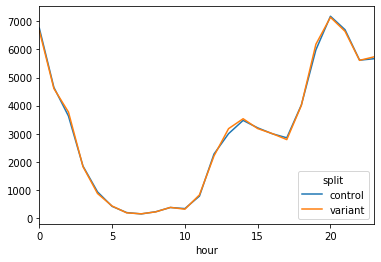

In [560]:
df['hour'] = df['created_timestamp_local'].dt.hour
df.pivot_table(index='hour' , columns='split' , values='order_id' , aggfunc=pd.Series.nunique ).plot()

In [561]:
# Label different time ranges
df['hour_ranges'] = pd.cut(df['hour'] , bins=[0 , 2 , 11 , 15 , 19 , 22] , labels=['high demand' , 'very low demand' , 
                                                                                  'regular demand' , 'low demand' ,
                                                                                   'super high demand'])
df.loc[df.hour_ranges.isnull() , 'hour_ranges'] = 'high demand'

In [562]:
demand = df.pivot_table(index='hour_ranges' , columns='split' , values=['order_id' , 'customer_id'] , aggfunc=pd.Series.nunique)

demand['order_per_user_control'] =  demand['order_id']['control'] / demand['customer_id']['control']
demand['order_per_user_variant'] =  demand['order_id']['variant'] / demand['customer_id']['variant']

In [563]:
demand['difference%'] = ((demand['order_per_user_variant'] / demand['order_per_user_control']) - 1)*100

In [564]:
# Summary table of order per user for different time ranges
demand

customer_id         order_id         order_per_user_control  \
split                 control variant  control variant                          
hour_ranges                                                                     
high demand             16427   16484    20709   20791               1.260668   
very low demand          4230    4195     5205    5152               1.230496   
regular demand          10300   10217    11956   12101               1.160777   
low demand              13880   13894    15859   15986               1.142579   
super high demand       16841   16835    19509   19408               1.158423   

                  order_per_user_variant difference%  
split                                                 
hour_ranges                                           
high demand                     1.261284    0.048804  
very low demand                 1.228129   -0.192421  
regular demand                  1.184399    2.035004  
low demand                      1.150569    0.699237  
super high demand               1.152836   -0.482254

Summary table shows not conclusion evidence , we can suspect a beterr performance in less peak hours

In [559]:
demand_m = df.pivot_table(index='hour_ranges' , columns='split' , values=['order_id' , 'order_value'] , 
                        aggfunc={'order_id' : pd.Series.nunique , 'order_value':'sum' }  )
demand_m['difference%_of_money'] = ((demand_m['order_value']['variant'] / demand_m['order_value']['control']) - 1)*100

demand_m['order_per_user_control'] =  demand_m['order_value']['control'] / demand_m['order_id']['control']
demand_m['order_per_user_variant'] =  demand_m['order_value']['variant'] / demand_m['order_id']['variant']
demand_m['difference%_of_money_per_order'] =  ((demand_m['order_per_user_variant'] / demand_m['order_per_user_control']) - 1)*100

print('Summary')
demand_m

order_id          order_value               \
split              control variant      control      variant   
hour_ranges                                                    
high demand          20709   20791  16630625.81  16546859.06   
very low demand       5205    5152   4265755.12   4319479.05   
regular demand       11956   12101  11419570.86  11838640.27   
low demand           15859   15986  17199782.63  17591206.77   
super high demand    19509   19408  20943310.29  21008130.79   

                  difference%_of_money order_per_user_control  \
split                                                           
hour_ranges                                                     
high demand                  -0.503690             803.062717   
very low demand               1.259424             819.549495   
regular demand                3.669747             955.133060   
low demand                    2.275751            1084.543958   
super high demand             0.309505            1073.520441   

                  order_per_user_variant difference%_of_money_per_order  
split                                                                    
hour_ranges                                                              
high demand                   795.866435                      -0.896105  
very low demand               838.408201                       2.301106  
regular demand                978.319169                       2.427527  
low demand                   1100.413285                       1.463226  
super high demand            1082.446970                       0.831519

Summary table shows that in less peak hours , people are spending more money could be corrolated with the fact that foodpand is making a better estimation of the delivery time during this hour

## Conclusion:

- Orders per user (+0,54%)
- Money spend : (+1%)
- Money spend per user (+1%)
- The new model performs better in model cluster 2 than old formula based on KPI's order per user , money spend and money spend per user. Model cluster 2 is usually more represented of more rural areas.
- There is no corrolation for distance and between the performance of the new model
- It's noted that in non peak hours the performance of the variant model is better (there is corrolation). Whenever there is high demand the variant seems not to be working better than the control formula , congestion of order seems to be a complicated hours to make a good prediction
- New model shows intresting good results but we should continue the experiment a little bit longer so as to validate the significance of results. There is no statistical significance yet. 

## Possible improvements:

- As stated before, the new model works better in non-peak hours based on the KPI's analyze. As such, we could focus on improving the performance of the model for peak hours.
- To evaluate better the algorithm would be nice to add the information of time arrival of the deliver. In that case we are going to be able to compare promised delivery time and the real time it takes to the deliver arrived (accuracy of estimation).
- Supposing that the food chains which dont want to foodpand be in charge of the delivery are "important" chains (important chains may not want to risk their delivers to a tertiary company , because they want to guarantee that food is been deliver on time). If that the case , we could build two delivery categories , one category would be the actual one and the new category could be a premium one which offers the chains that they would guarantee extra personal and service for delivery arrived on time (this should be always be cheaper than the food chain set their own delivery personals). 